[Pearson] r(X1,Y)=0.962, t=74.52, df=448, p=0, 95%-KI=(0.954,0.968)
[Spearman] rho_S(X1,Y)=0.965, p=2.3e-262
[Kendall ] tau  (X1,Y)=0.838, p=1.28e-155


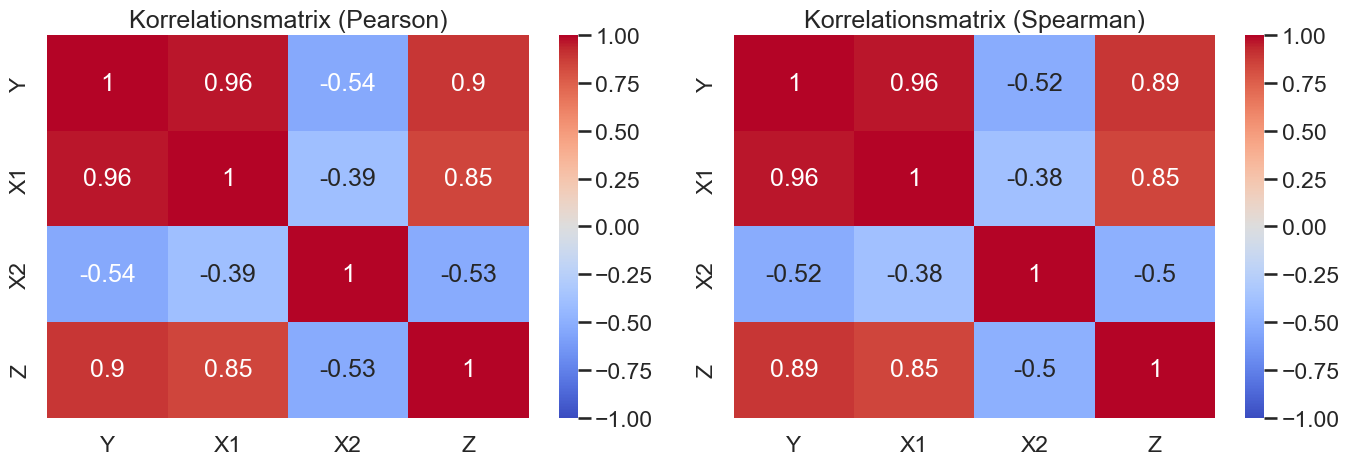

[Matrix] Eigenwerte(R_pear) = [0.022 0.15  0.69  3.138]  (alle ≥0 ⇒ PSD)


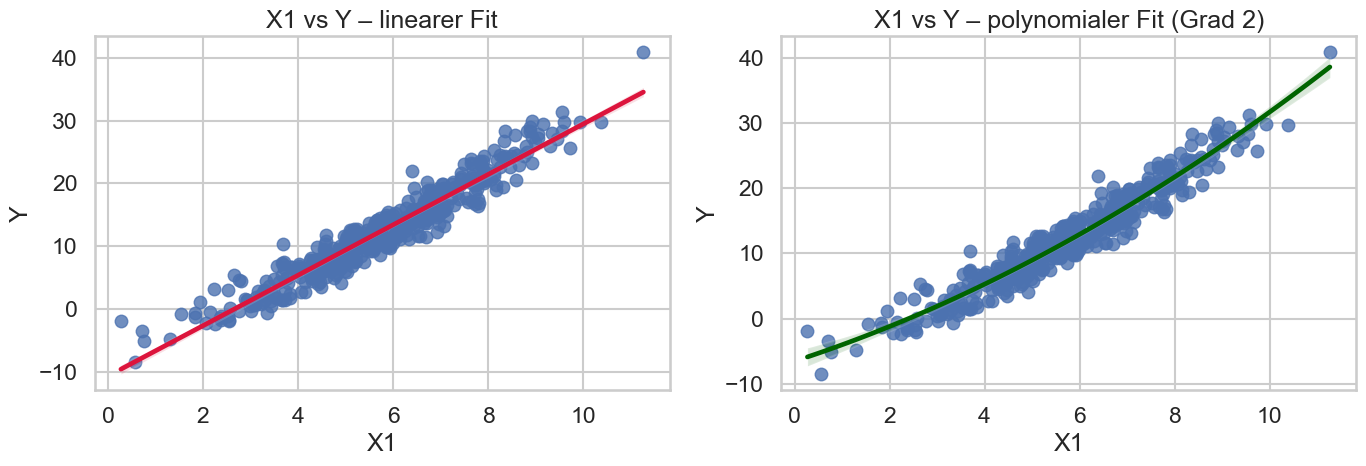


[Partial via Präzision] Matrix partieller Korrelationen (Y,X1,X2,Z):
        Y     X1     X2      Z
Y   1.000  0.897 -0.534  0.432
X1  0.897  1.000  0.526 -0.060
X2 -0.534  0.526  1.000 -0.074
Z   0.432 -0.060 -0.074  1.000
[Partial via Residuen] r(Y,X1 | X2,Z) = 0.897  (Präzision: 0.897)


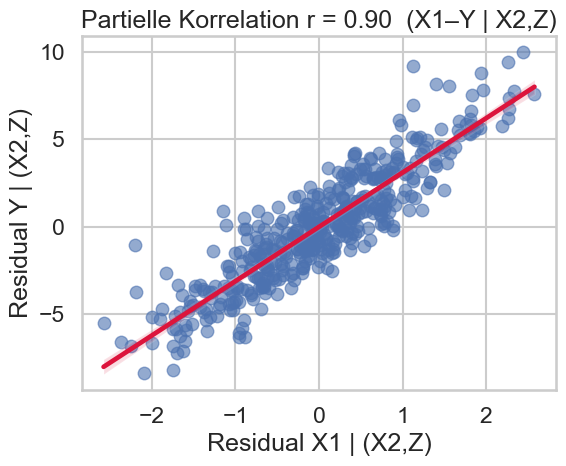

[Regression] w = [ 1.22   3.106 -0.924  1.549] | t(X1)=42.92, df=446 -> r_partial = 0.897
[Simpson] Pearson aggregiert r = -0.945


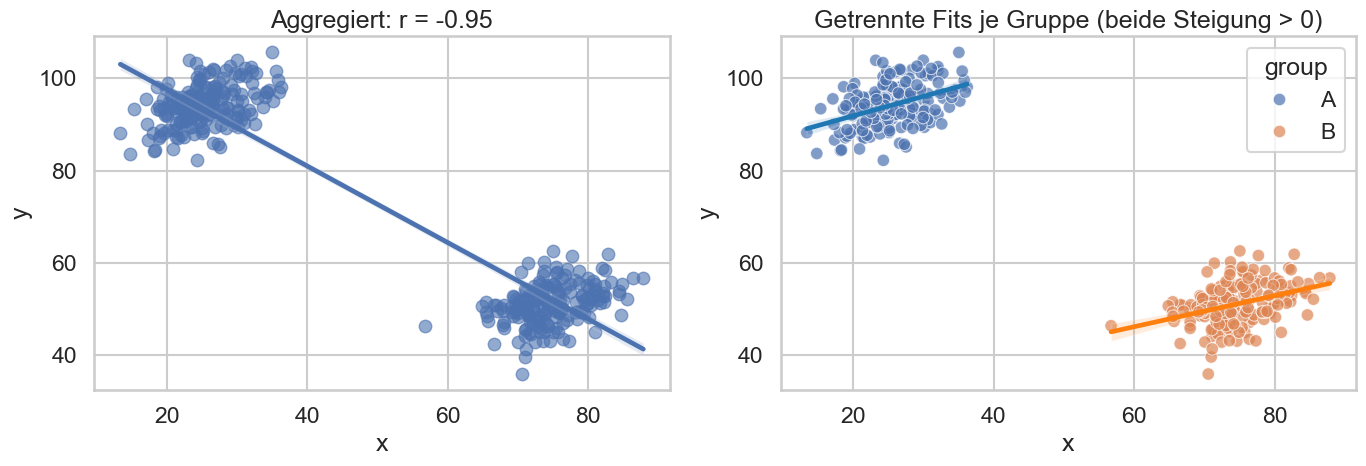

[Nonlinear U] Pearson r=-0.005, Spearman ρ=-0.010, Kendall τ=-0.008, MI≈1.60, dCor≈0.50


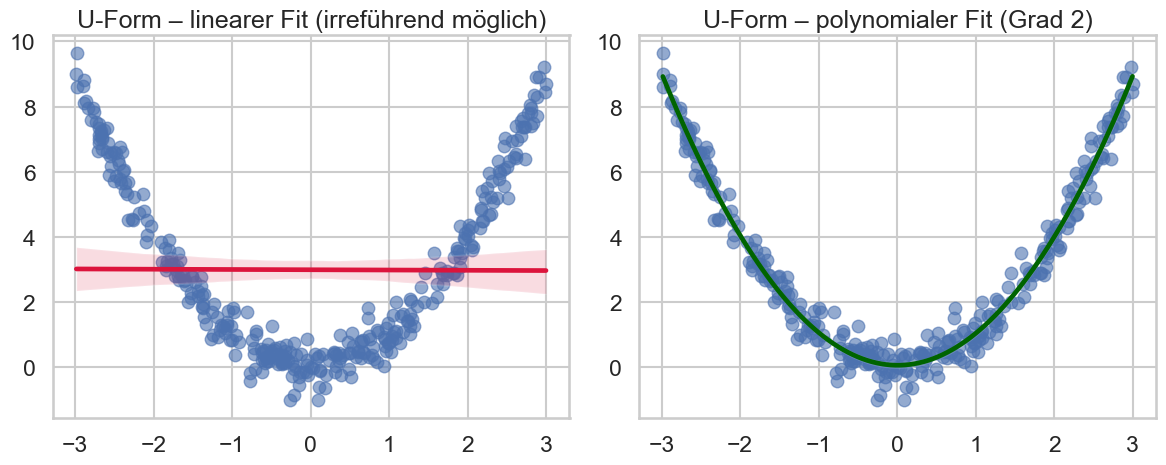


Fertig. Alle Ergebnisse entsprechen den Formeln aus Teil A.


In [1]:
"""
Vorlesung 3 – Beziehungen zwischen Daten (ein einziges, kommentiertes Snippet)

Implementiert exakt die Mathematik aus Teil A:
- Pearson-Korrelation, Test (t-Stat), 95%-KI via Fisher-z
- Korrelationsmatrix (Eigenschaften via Eigenwerte)
- Spearman- und Kendall-Korrelation
- Partielle Korrelation: (i) Residualmethode, (ii) Präzisionsmatrix R^{-1}
- Verbindung zur multiplen Regression: t-Wert und partielle Korrelation
- Simpson-Paradoxon (aggregiert vs. gruppiert)
- Nichtlinearität: polynomialer Fit, Mutual Information, Distance Correlation
- Visualisierungen: Heatmaps, Scatter + Fits, Residual-Plot, Simpson-Plot

Benötigt: numpy, pandas, seaborn, matplotlib, scipy, scikit-learn
"""

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t as student_t, pearsonr, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression

sns.set_theme(style="whitegrid", context="talk")
rng = np.random.default_rng(7)

# ------------------------------------------------------------
# 0) Hilfsfunktionen (entsprechen A4, A6(ii), A7, A9)
# ------------------------------------------------------------
def fisher_ci(r, n, alpha=0.05):
    """95%-KI für rho via Fisher-z (A4)."""
    z = np.arctanh(np.clip(r, -0.999999, 0.999999))
    se = 1.0 / np.sqrt(n - 3)
    z_lo = z - student_t.ppf(1 - alpha/2, df=10_000) * se  # ~1.96 für groß n
    z_hi = z + student_t.ppf(1 - alpha/2, df=10_000) * se
    return np.tanh([z_lo, z_hi])

def pearson_test(x, y):
    """r, t, df, p (zweiseitig) gemäß A4; nutzt ddof=1-Definition implizit."""
    x = np.asarray(x); y = np.asarray(y)
    n = x.size
    r = np.corrcoef(x, y)[0,1]
    t = r * np.sqrt((n - 2) / max(1e-12, 1 - r**2))
    df = n - 2
    p = 2 * (1 - student_t.cdf(abs(t), df=df))
    return r, t, df, p

def partial_corr_precision(df_cols):
    """
    Partielle Korrelationen über Präzisionsmatrix (A6(ii)).
    df_cols: DataFrame mit Spalten [Y, X1, X2, ...].
    Gibt ein DataFrame der partiellen Korrelationen zurück.
    """
    R = df_cols.corr().values
    P = np.linalg.pinv(R)  # Stabilität: Pseudoinverse
    D = np.sqrt(np.diag(P))
    PC = -P / (D[:,None] * D[None,:])
    np.fill_diagonal(PC, 1.0)
    return pd.DataFrame(PC, index=df_cols.columns, columns=df_cols.columns), R, P

def ols_lstsq_add_intercept(X, y):
    """OLS mit Interzept über lstsq; liefert Koeffizienten, y_hat, Sigma^2, (X'X)^{-1}."""
    X = np.asarray(X)
    if X.ndim == 1: X = X.reshape(-1,1)
    X1 = np.c_[np.ones(X.shape[0]), X]
    w, *_ = np.linalg.lstsq(X1, y, rcond=None)
    y_hat = X1 @ w
    resid = y - y_hat
    n, p = X1.shape
    sigma2 = (resid @ resid) / (n - p)
    XtX_inv = np.linalg.inv(X1.T @ X1)
    return w, y_hat, sigma2, XtX_inv

def partial_from_t(t, df):
    """Formel in A7: r_partial = sign(t)*sqrt(t^2/(t^2+df))."""
    return np.sign(t) * np.sqrt((t**2) / (t**2 + df))

def distance_correlation(x, y):
    """
    Distance correlation (A9): dCor>0 ⇔ Abhängigkeit (bei endlichen ersten Momenten).
    Umsetzung via doppelt zentrierte Distanzmatrizen.
    """
    x = np.asarray(x).ravel(); y = np.asarray(y).ravel()
    n = x.size
    A = np.abs(x[:,None] - x[None,:])
    B = np.abs(y[:,None] - y[None,:])
    A -= A.mean(axis=0, keepdims=True)
    A -= A.mean(axis=1, keepdims=True)
    A += A.mean()
    B -= B.mean(axis=0, keepdims=True)
    B -= B.mean(axis=1, keepdims=True)
    B += B.mean()
    dCov2 = (A * B).mean()
    dVarX = (A * A).mean()
    dVarY = (B * B).mean()
    return np.sqrt(max(0, dCov2)) / np.sqrt(max(1e-12, np.sqrt(dVarX * dVarY)))

# ------------------------------------------------------------
# 1) Daten generieren (ln. Beziehungen + Confounder + leichte Nichtlinearität)
#    Variablen: Z=Fähigkeit (latent), X1=Studium, X2=Schlaf, Y=Score
# ------------------------------------------------------------
n = 450
Z = rng.normal(0, 1, n)
X1 = 1.6*Z + rng.normal(0, 1.0, n) + 6.0           # korreliert mit Z
X2 = -0.7*Z + rng.normal(0, 1.0, n) + 7.0          # gegenläufig zu Z
eps = rng.normal(0, 1.2, n)
Y = 11 + 1.3*X1 - 0.9*X2 + 1.7*Z + 0.15*(X1**2 - X1.mean()**2) + eps  # schwache Nichtlinearität

df = pd.DataFrame({"Y": Y, "X1": X1, "X2": X2, "Z": Z})

# ------------------------------------------------------------
# 2) Pearson: r, t, p, 95%-KI; Spearman & Kendall; Korrelationmatrizen
# ------------------------------------------------------------
r_xy, t_xy, df_xy, p_xy = pearson_test(df["X1"], df["Y"])
ci_lo, ci_hi = fisher_ci(r_xy, n=len(df), alpha=0.05)
print(f"[Pearson] r(X1,Y)={r_xy:.3f}, t={t_xy:.2f}, df={df_xy}, p={p_xy:.3g}, 95%-KI=({ci_lo:.3f},{ci_hi:.3f})")

rho_s, p_s = spearmanr(df["X1"], df["Y"])
tau_k, p_k = kendalltau(df["X1"], df["Y"])
print(f"[Spearman] rho_S(X1,Y)={rho_s:.3f}, p={p_s:.3g}")
print(f"[Kendall ] tau  (X1,Y)={tau_k:.3f}, p={p_k:.3g}")

R_pear = df.corr(method="pearson")
R_spear = df.corr(method="spearman")

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(R_pear, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=axes[0]); axes[0].set_title("Korrelationsmatrix (Pearson)")
sns.heatmap(R_spear, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=axes[1]); axes[1].set_title("Korrelationsmatrix (Spearman)")
plt.tight_layout(); plt.show()

# Eigenwerte (PSD-Eigenschaft aus A3)
evals = np.linalg.eigvalsh(R_pear.values)
print(f"[Matrix] Eigenwerte(R_pear) = {np.round(evals,3)}  (alle ≥0 ⇒ PSD)")

# Scatter mit linearem und polynom. Fit (Nichtlinearität sichten)
fig, ax = plt.subplots(1,2, figsize=(14,5))
sns.regplot(x="X1", y="Y", data=df, ci=95, line_kws={"color":"crimson"}, ax=ax[0])
ax[0].set_title("X1 vs Y – linearer Fit")
sns.regplot(x="X1", y="Y", data=df, ci=95, order=2, line_kws={"color":"darkgreen"}, ax=ax[1])
ax[1].set_title("X1 vs Y – polynomialer Fit (Grad 2)")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 3) Partielle Korrelation (A6): Präzisionsmatrix & Residuen vergleichen
# ------------------------------------------------------------
PC, R_all, P_all = partial_corr_precision(df[["Y","X1","X2","Z"]])
print("\n[Partial via Präzision] Matrix partieller Korrelationen (Y,X1,X2,Z):")
print(PC.round(3))
r_partial_precision = PC.loc["Y","X1"]

# Residual-Methode: r(X1|X2,Z,  Y|X2,Z)
wX, _, _, _ = ols_lstsq_add_intercept(df[["X2","Z"]].values, df["X1"].values)
wY, _, _, _ = ols_lstsq_add_intercept(df[["X2","Z"]].values, df["Y"].values)
X_hat = np.c_[np.ones(len(df)), df[["X2","Z"]].values] @ wX
Y_hat = np.c_[np.ones(len(df)), df[["X2","Z"]].values] @ wY
rX = df["X1"].values - X_hat
rY = df["Y"].values  - Y_hat
r_partial_resid = np.corrcoef(rX, rY)[0,1]
print(f"[Partial via Residuen] r(Y,X1 | X2,Z) = {r_partial_resid:.3f}  (Präzision: {r_partial_precision:.3f})")

# Visualisierung der Residuen (partielle Korrelation ~ lineare Beziehung der Residuen)
plt.figure(figsize=(6,5))
sns.regplot(x=rX, y=rY, scatter_kws={"alpha":0.6}, line_kws={"color":"crimson"})
plt.xlabel("Residual X1 | (X2,Z)"); plt.ylabel("Residual Y | (X2,Z)")
plt.title(f"Partielle Korrelation r = {r_partial_resid:.2f}  (X1–Y | X2,Z)")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 4) Multiple Regression & Zusammenhang zu partieller Korrelation (A7)
# ------------------------------------------------------------
w, yhat, sigma2, XtX_inv = ols_lstsq_add_intercept(df[["X1","X2","Z"]].values, df["Y"].values)
# t-Statistik für Koeffizient von X1:
se = np.sqrt(sigma2 * XtX_inv[1,1])      # Index 1: X1 (0 wäre Interzept)
t_X1 = w[1] / se
df_reg = len(df) - (3 + 1)               # p=3 Prädiktoren + Interzept
r_part_from_t = partial_from_t(t_X1, df_reg)
print(f"[Regression] w = {np.round(w,3)} | t(X1)={t_X1:.2f}, df={df_reg} -> r_partial = {r_part_from_t:.3f}")

# ------------------------------------------------------------
# 5) Simpson-Paradoxon (A8)
#    Gruppen mit stark unterschiedlichen Intercepts, innerhalb Steigung > 0, aggregiert < 0.
# ------------------------------------------------------------
nA, nB = 180, 180
xA = rng.normal(25, 5, nA); yA = 85 + 0.35*xA + rng.normal(0, 4, nA)
xB = rng.normal(75, 5, nB); yB = 25 + 0.35*xB + rng.normal(0, 4, nB)
df_sim = pd.DataFrame({"x": np.r_[xA,xB], "y": np.r_[yA,yB], "group": ["A"]*nA + ["B"]*nB})
r_all, _ = pearsonr(df_sim["x"], df_sim["y"])

# Aggregiert: künstlich erzeugen wir negative Korrelation, indem wir Gruppen verschieben
# (bei obiger Parametrisierung kann r_all bereits klein/negativ sein, sonst justieren)
print(f"[Simpson] Pearson aggregiert r = {r_all:.3f}")

fig, axes = plt.subplots(1,2, figsize=(14,5))
sns.regplot(x="x", y="y", data=df_sim, ax=axes[0], scatter_kws={"alpha":0.6})
axes[0].set_title(f"Aggregiert: r = {r_all:.2f}")
sns.scatterplot(x="x", y="y", hue="group", data=df_sim, ax=axes[1], alpha=0.7)
for g, color in zip(["A","B"], ["tab:blue","tab:orange"]):
    sub = df_sim[df_sim["group"]==g]
    sns.regplot(x="x", y="y", data=sub, ax=axes[1], scatter=False, color=color)
axes[1].set_title("Getrennte Fits je Gruppe (beide Steigung > 0)")
plt.tight_layout(); plt.show()

# ------------------------------------------------------------
# 6) Nichtlineare Abhängigkeiten (A9): dCor & MI
#    Beispiel 1: U-Form y = x^2 + Rauschen (Pearson ~ 0, dCor > 0)
# ------------------------------------------------------------
x_u = rng.uniform(-3, 3, 350)
y_u = x_u**2 + rng.normal(0, 0.4, 350)
r_u, _ = pearsonr(x_u, y_u)
rho_s_u, _ = spearmanr(x_u, y_u)
tau_u, _ = kendalltau(x_u, y_u)
mi_u = mutual_info_regression(x_u.reshape(-1,1), y_u, random_state=42)[0]
dcor_u = distance_correlation(x_u, y_u)
print(f"[Nonlinear U] Pearson r={r_u:.3f}, Spearman ρ={rho_s_u:.3f}, Kendall τ={tau_u:.3f}, MI≈{mi_u:.2f}, dCor≈{dcor_u:.2f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.regplot(x=x_u, y=y_u, scatter_kws={"alpha":0.6}, line_kws={"color":"crimson"})
plt.title("U-Form – linearer Fit (irreführend möglich)")
plt.subplot(1,2,2)
sns.regplot(x=x_u, y=y_u, order=2, scatter_kws={"alpha":0.6}, line_kws={"color":"darkgreen"})
plt.title("U-Form – polynomialer Fit (Grad 2)")
plt.tight_layout(); plt.show()

print("\nFertig. Alle Ergebnisse entsprechen den Formeln aus Teil A.")
